In [8]:
#Author: Aaron Hertner
#Version: Python Base 3.8
#Purpose: To test various anomaly detection models, and preprocessing techniques, on log anomaly data sets

In [9]:
import warnings

#graphing and util
from matplotlib.cbook import mplDeprecation
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sb
from collections import Counter
import time
from ipywidgets import interact, interactive

#preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder

#ML Libraries
from sklearn.model_selection import train_test_split

#ML Models
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

warnings.filterwarnings("ignore",category=mplDeprecation)

In [10]:
df = pd.read_csv('../_datasets/bike_sharing_daily.csv')

pd.options.display.max_columns = None
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [11]:
df = df.drop(['instant','dteday', 'holiday','weekday','workingday', 'weathersit'], axis=1)
df.head()

,season,yr,mnth,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0.344167,0.363625,0.805833,0.160446,331,654,985
1,1,0,1,0.363478,0.353739,0.696087,0.248539,131,670,801
2,1,0,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,1,0,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,1,0,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [12]:
df.isnull().sum()

season        0
yr            0
mnth          0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [13]:
df.shape

(731, 10)

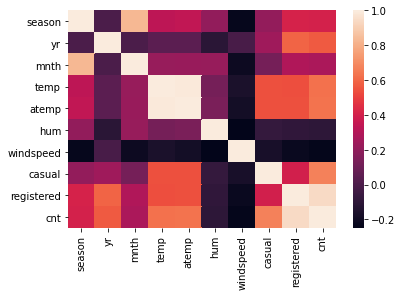

In [14]:
sb.heatmap(df.corr())

In [15]:
pca = PCA()
df = pd.DataFrame(pca.fit_transform(df), columns = df.columns)

sc = StandardScaler()
df = pd.DataFrame(sc.fit_transform(df), columns = df.columns)

df.head()

,season,yr,mnth,temp,atemp,hum,windspeed,casual,registered,cnt
0,1.867846,0.467607,-1.060499,-0.515815,0.105177,0.949875,-1.087498,-0.546871,-1.025990,-11.291096
1,1.934714,0.152726,-1.060431,-0.537558,0.096438,0.779623,-0.038045,0.264143,0.017856,21.140413
2,1.627579,-0.099656,-1.173981,-0.458613,-0.067253,-1.402976,0.527050,-0.070455,0.763924,4.697791
3,1.506824,-0.212907,-1.218450,-0.452844,-0.208243,-0.961290,-0.709530,-0.767603,0.108656,4.428735
4,1.481034,-0.279921,-1.231334,-0.449234,-0.264009,-1.273936,0.472759,-0.910757,0.292433,-1.176955


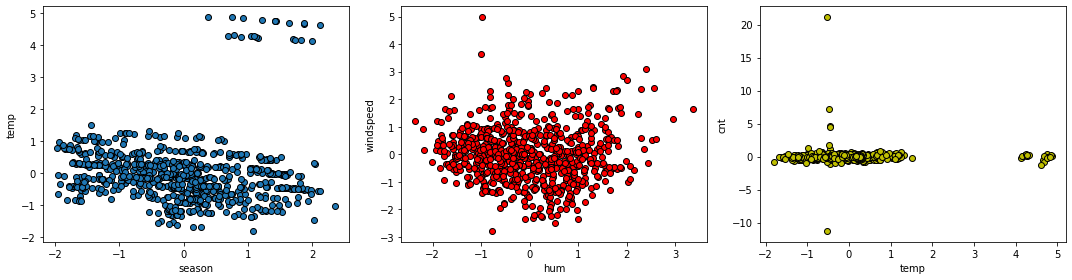

In [16]:
fig, axarr = plt.subplots(1,3,figsize = (15,4))

axarr[0].scatter(df['season'], df['temp'], edgecolors='k')
axarr[0].set_xlabel('season')
axarr[0].set_ylabel('temp')

axarr[1].scatter(df['hum'], df['windspeed'], color = 'r', edgecolors='k')
axarr[1].set_xlabel('hum')
axarr[1].set_ylabel('windspeed')

axarr[2].scatter(df['temp'], df['cnt'], color='y', edgecolors='k')
axarr[2].set_xlabel('temp')
axarr[2].set_ylabel('cnt')

plt.tight_layout()

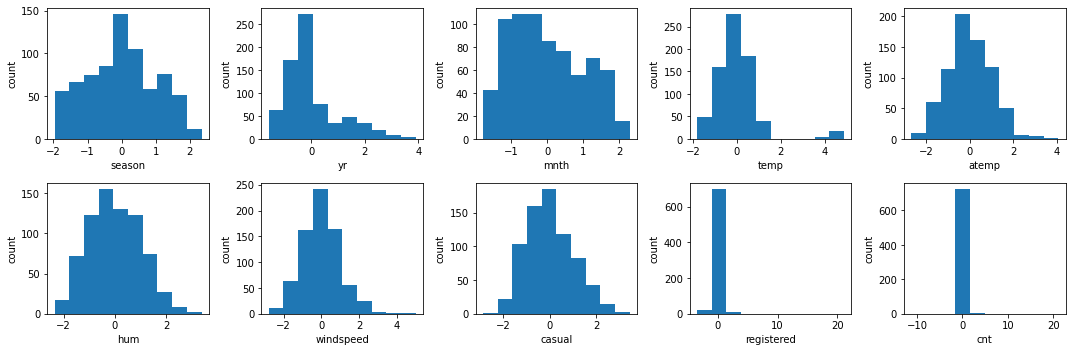

In [17]:
fig, axarr = plt.subplots(2,5, figsize=(15,5))

i = 0
for col in df.columns:
    axarr[i//5][i%5].hist(df[col])
    axarr[i//5][i%5].set_xlabel(f'{col}')
    axarr[i//5][i%5].set_ylabel('count')
    i += 1
    
plt.tight_layout()

In [18]:
models = [('IsoF', IsolationForest()), 
          ('LOF', LocalOutlierFactor(novelty = True)),
          ('OCSvm', OneClassSVM()),
          ('EEnv', EllipticEnvelope())]

x_train, x_test = train_test_split(df, test_size = 0.2, random_state = 0)

preds = []
for i in range(len(models)):
    start = time.time()
    models[i][1].fit(x_train)
    y_pred = models[i][1].predict(x_test)
    end = time.time() - start
    preds.append(y_pred)
    anoms = (y_pred == -1).sum()
    reg_dat = (y_pred == 1).sum()
    print(f'y_pred: {models[i][0]} | TIME(s) - %.2f | ANOMALIES - {anoms}/4080|'%end)

y_pred: IsoF | TIME(s) - 0.21 | ANOMALIES - 21/4080|
y_pred: LOF | TIME(s) - 0.02 | ANOMALIES - 4/4080|
y_pred: OCSvm | TIME(s) - 0.03 | ANOMALIES - 75/4080|
y_pred: EEnv | TIME(s) - 0.68 | ANOMALIES - 20/4080|


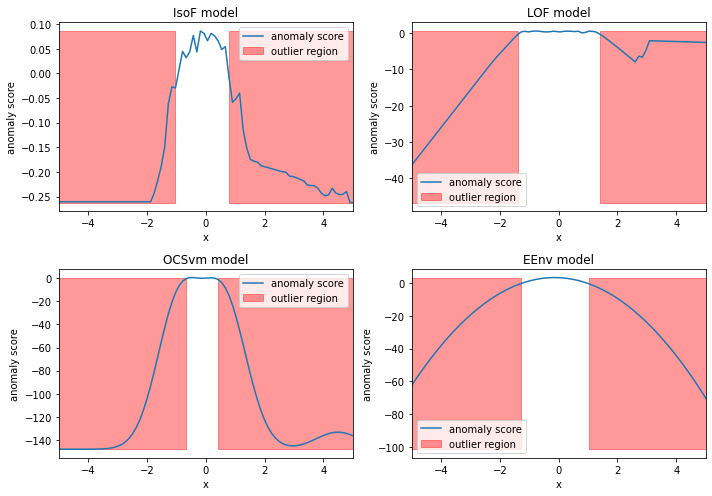

In [20]:
fig, axarr = plt.subplots(2,2, figsize=(10,7))
for i in range(len(models)):
    models[i][1].fit(np.array(x_train['temp']).reshape(-1,1))
    xx = np.linspace(-6, 6, 100).reshape(-1,1)
    anomaly_score = models[i][1].decision_function(xx)
    outlier = models[i][1].predict(xx)

    axarr[i//2][i%2].plot(xx, anomaly_score, label='anomaly score')
    axarr[i//2][i%2].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
    axarr[i//2][i%2].legend()
    axarr[i//2][i%2].set_ylabel('anomaly score')
    axarr[i//2][i%2].set_xlabel('x')
    axarr[i//2][i%2].set_xlim([-5, 5])
    axarr[i//2][i%2].set_title(f'{models[i][0]} model')
    
plt.tight_layout()

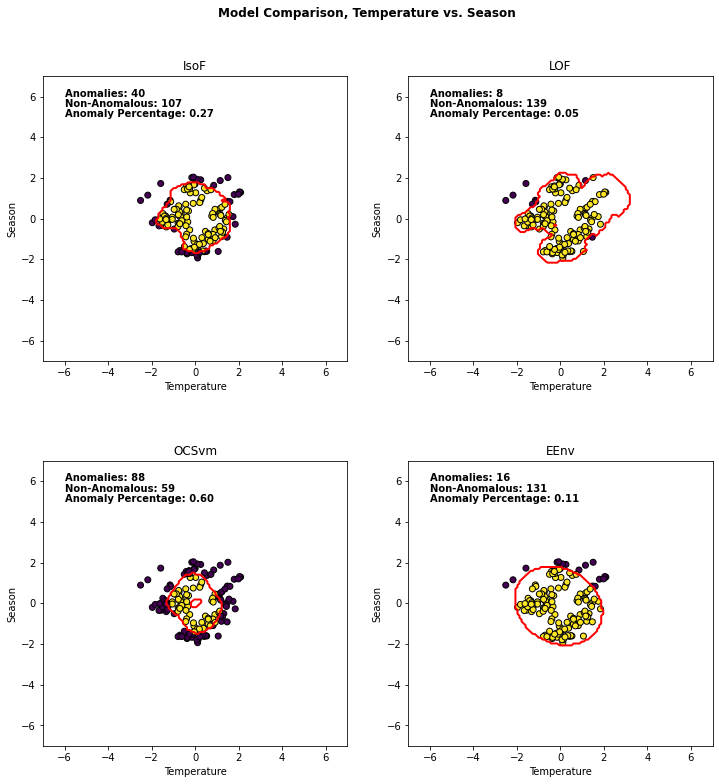

In [39]:
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))

fig, axarr = plt.subplots(2,2,figsize=(12,12))
i = 0
for model in models:
    model[1].fit(x_train[['atemp','season']])
    Z = model[1].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    c = model[1].predict(x_test[['atemp','season']])
    anoms = (c == -1).sum()
    non_anom = (c == 1).sum()
    anom_per = anoms / (anoms + non_anom)
    axarr[i//2][i%2].contour(xx, yy, Z, levels=[0], linewidths=2, colors='r')
    axarr[i//2][i%2].scatter(x_test['atemp'], x_test['season'], c=c, edgecolors='k')
    axarr[i//2][i%2].set_title(model[0])
    axarr[i//2][i%2].set_xlabel('Temperature')
    axarr[i//2][i%2].set_ylabel('Season')
    axarr[i//2][i%2].annotate(f'Anomalies: {anoms}', xy=(-6, 6), fontweight='bold')
    axarr[i//2][i%2].annotate(f'Non-Anomalous: {non_anom}', xy=(-6, 5.5), fontweight='bold')
    axarr[i//2][i%2].annotate('Anomaly Percentage: %.2f'%anom_per, xy=(-6, 5), fontweight='bold')
    i += 1

fig.suptitle('Model Comparison, Temperature vs. Season', fontweight='bold')
fig.subplots_adjust(top=0.9, hspace=0.35)


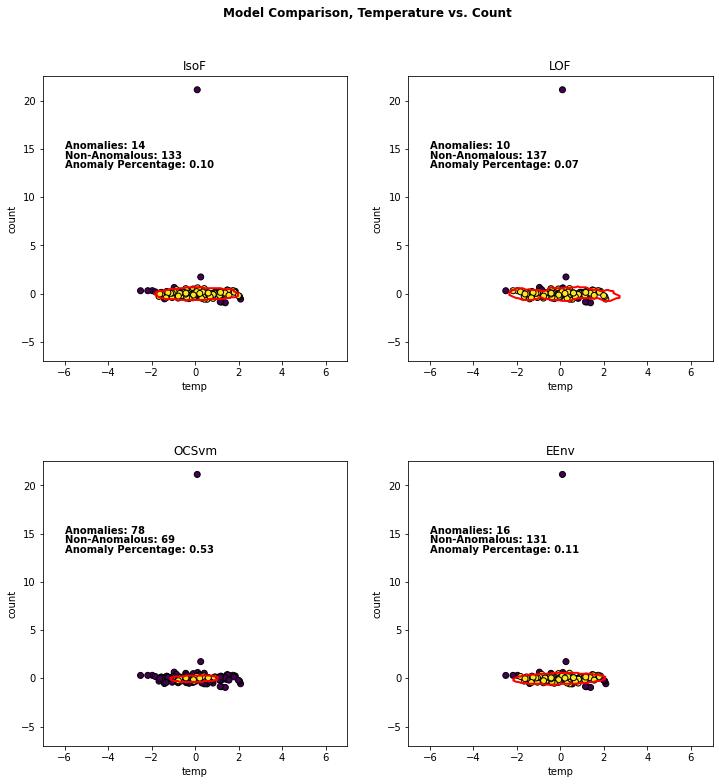

In [38]:
xx, yy = np.meshgrid(np.linspace(-7, 7, 150),
                     np.linspace(-7, 7, 150))

fig, axarr = plt.subplots(2,2,figsize=(12,12))
i = 0
for model in models:
    model[1].fit(x_train[['atemp','cnt']])
    Z = model[1].predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    c = model[1].predict(x_test[['atemp','cnt']])
    anoms = (c == -1).sum()
    non_anom = (c == 1).sum()
    anom_per = anoms / (anoms + non_anom)
    axarr[i//2][i%2].contour(xx, yy, Z, levels=[0], linewidths=2, colors='r')
    axarr[i//2][i%2].scatter(x_test['atemp'], x_test['cnt'], c=c, edgecolors='k')
    axarr[i//2][i%2].set_title(model[0])
    axarr[i//2][i%2].set_xlabel('temp')
    axarr[i//2][i%2].set_ylabel('count')
    axarr[i//2][i%2].annotate(f'Anomalies: {anoms}', xy=(-6, 15), fontweight='bold')
    axarr[i//2][i%2].annotate(f'Non-Anomalous: {non_anom}', xy=(-6, 14), fontweight='bold')
    axarr[i//2][i%2].annotate('Anomaly Percentage: %.2f'%anom_per, xy=(-6, 13), fontweight='bold')
    i += 1

fig.suptitle('Model Comparison, Temperature vs. Count', fontweight='bold')
fig.subplots_adjust(top=0.9, hspace=0.35)

In [24]:
iso = IsolationForest(n_estimators=100)
iso.fit(x_train)
y_pred = iso.predict(x_test)

def on_change(elevation, rotation):
    fig = plt.figure(1, figsize=(5,5))
    plt.clf()
    ax = fig.add_axes(Axes3D(fig, elev=elevation, azim=rotation))
    ax.scatter(x_test['temp'], x_test['season'], x_test['cnt'], c=y_pred, cmap = plt.cm.get_cmap('plasma'))
    ax.set_title('Isolation Forest Anomaly Detection Predictions')
    return elevation, rotation

interactive_plot = interactive(on_change, elevation=(0, 90, 0.1), rotation=(0, 90 ,0.1))
output = interactive_plot.children[-1]
output.layout.height = '360px'
interactive_plot

interactive(children=(FloatSlider(value=45.0, description='elevation', max=90.0), FloatSlider(value=45.0, desc…